# EMNIST digit classification

## Results of this model on MNIST test data: 
1. 0.22% test error rate with ensemble of 10 CNNs
2. 0.21% test error rate with ensemble of 6 selected CNNs
3. 0.26% test error rate for best single model (model was trained for a few more epochs)

## Test error rates of this model on EMNIST test data: 

In [37]:
%matplotlib inline

In [38]:
import keras
import numpy as np
from keras.datasets import mnist
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D
from keras.layers import Flatten, Lambda, BatchNormalization
from keras.models import Sequential
from keras.optimizers import Adam as Adam

# try leaky relu
from keras.layers.advanced_activations import LeakyReLU

# used to save and load training histories
import pickle
from collections import defaultdict

# Load MNIST dataset

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# store labels on test set for visualization
test_labels = y_test

In [4]:
x_train.shape

(60000, 28, 28)

In [5]:
# vgg expects channels - here we have just one
x_train = x_train.reshape(x_train.shape[0], 1, 28, 28)
x_test = x_test.reshape(x_test.shape[0], 1, 28, 28)
x_train.shape

(60000, 1, 28, 28)

In [6]:
# convert to float
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

# normalize
x_train /= 255
x_test /= 255

In [8]:
y_train.shape

(60000,)

In [9]:
# labels should be onehot encoded
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

y_train.shape

(60000, 10)

In [10]:
y_train[:5]

array([[ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]])

# Load EMNIST dataset
Introduced by https://arxiv.org/abs/1702.05373v1 downloaded from https://www.nist.gov/itl/iad/image-group/emnist-dataset (Matlab format dataset). The matlab format dataset can be conveniently imported with scipy.io.loadmat.

In [39]:
from scipy import io as spio

In [40]:
emnist = spio.loadmat("datasets/matlab/emnist-digits.mat")

In [41]:
# load training dataset
X_train_emnist = emnist["dataset"][0][0][0][0][0][0]
X_train_emnist = X_train_emnist.astype(np.float32)

# load training labels
y_train_emnist = emnist["dataset"][0][0][0][0][0][1]

In [42]:
# load test dataset
X_test_emnist = emnist["dataset"][0][0][1][0][0][0]
X_test_emnist = X_test_emnist.astype(np.float32)

# load test labels
y_test_emnist = emnist["dataset"][0][0][1][0][0][1]

In [43]:
# store labels for visualization
train_labels_emnist = y_train_emnist
test_labels_emnist = y_test_emnist

In [44]:
X_train_emnist.shape

(240000, 784)

In [45]:
y_train_emnist.shape

(240000, 1)

In [46]:
# normalize
X_train_emnist /= 255
X_test_emnist /= 255

In [47]:
X_train_emnist

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)

In [48]:
# reshape using matlab order
X_train_emnist = X_train_emnist.reshape(X_train_emnist.shape[0], 1, 28, 28, order="A")
X_test_emnist = X_test_emnist.reshape(X_test_emnist.shape[0], 1, 28, 28, order="A")

In [49]:
X_train_emnist.shape

(240000, 1, 28, 28)

In [50]:
y_train_emnist.shape

(240000, 1)

In [51]:
# labels should be onehot encoded
y_train_emnist = keras.utils.to_categorical(y_train_emnist, 10)
y_test_emnist = keras.utils.to_categorical(y_test_emnist, 10)

y_train_emnist.shape

(240000, 10)

### verify we have imported the data correctly

In [52]:
# which sample to look at
samplenum = 5437

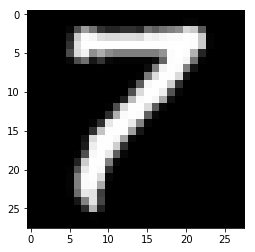

In [53]:
import matplotlib.pyplot as plt

img = X_train_emnist[samplenum]

# visualize image
plt.imshow(img[0], cmap='gray')

In [54]:
# show label for sample image
train_labels_emnist[samplenum][0]

7

# Use EMNIST dataset instead of MNIST

In [55]:
x_train = X_train_emnist
y_train = y_train_emnist

x_test = X_test_emnist
y_test = y_test_emnist

test_labels = test_labels_emnist

In [56]:
test_labels = test_labels.reshape(40000)

In [57]:
test_labels.shape

(40000,)

# Define model

In [58]:
# calculate mean and standard deviation
mean_px = x_train.mean().astype(np.float32)
std_px = x_train.std().astype(np.float32)

In [59]:
# function to normalize input data
def norm_input(x): return (x-mean_px)/std_px

In [60]:
# Batchnorm + dropout + data augmentation
def create_model():
    model = Sequential([
        Lambda(norm_input, input_shape=(1,28,28), output_shape=(1,28,28)),
        Conv2D(32, (3,3)),
        LeakyReLU(),
        BatchNormalization(axis=1),
        Conv2D(32, (3,3)),
        LeakyReLU(),
        MaxPooling2D(),
        BatchNormalization(axis=1),
        Conv2D(64, (3,3)),
        LeakyReLU(),
        BatchNormalization(axis=1),
        Conv2D(64, (3,3)),
        LeakyReLU(),
        MaxPooling2D(),
        Flatten(),
        BatchNormalization(),
        Dense(512),
        LeakyReLU(),
        BatchNormalization(),
        Dropout(0.3),
        Dense(10, activation='softmax')
    ])
    model.compile(Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Data augmentation
Use keras's data augmentation.

In [61]:
batch_size = 512

In [62]:
from keras.preprocessing.image import ImageDataGenerator

In [63]:
gen = ImageDataGenerator(rotation_range=12, width_shift_range=0.1, shear_range=0.3,
                        height_shift_range=0.1, zoom_range=0.1, data_format='channels_first')
batches = gen.flow(x_train, y_train, batch_size=batch_size)
test_batches = gen.flow(x_test, y_test, batch_size=batch_size)
steps_per_epoch = int(np.ceil(batches.n/batch_size))
validation_steps = int(np.ceil(test_batches.n/batch_size))

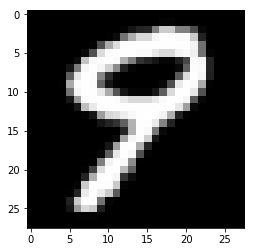

In [64]:
import matplotlib.pyplot as plt

# load ONE image from training set to display on screen
img = x_train[1]

# visualize original image
plt.imshow(img[0], cmap='gray')

In [65]:
# trick our generator into believing img has enough dimensions
# and get some augmented images for our single test image
img = np.expand_dims(img, axis=0)
aug_iter = gen.flow(img)

In [66]:
aug_img = next(aug_iter)[0].astype(np.float32)
aug_img.shape

(1, 28, 28)

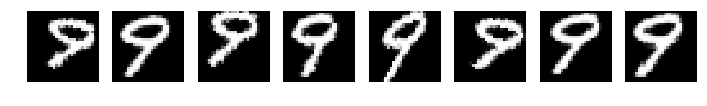

In [67]:
import matplotlib.pyplot as plt

# show augmented images
f = plt.figure(figsize=(12,6))
for i in range(8):
    sp = f.add_subplot(2, 26//3, i+1)
    sp.axis('Off')
    aug_img = next(aug_iter)[0].astype(np.float32)
    plt.imshow(aug_img[0], cmap='gray')

# Create models using saved weights

In [29]:
models = []

for i in range(10):
    m = create_model()
    m.load_weights('weights/128epochs_weights_model_'+str(i)+'.pkl')
    models.append(m)

# Ensembling
Here we create ten models and fit them to our augmented data. We use the mean prediction from all ten classifiers as our final prediction. This should average out errors in our classifiers and enable us to predict with higher accuracy.

In [23]:
import resource, sys

# we would reach recursion limit when saving training history otherwise
resource.setrlimit(resource.RLIMIT_STACK, (2**29,-1))
sys.setrecursionlimit(10**6)

## Create and train ten models

In [26]:
models = []
histories = []

# create and train ten models
for i in range(10):
    m = create_model()
    h = m.fit_generator(batches, steps_per_epoch=steps_per_epoch, epochs=32, verbose=0,
                        validation_data=test_batches, validation_steps=validation_steps)
    # save model weights
    m.save_weights("weights/32epochs_weights_model_{}.pkl".format(str(i)))
    # save corresponding training history
    f = open("history/32epochs_history_model_{}.pkl".format(str(i)),"wb")
    pickle.dump(h, f)
    f.close()
    
    models.append(m)
    histories.append(h)

### Train models for a few more epochs
Training 10 models for 16 epochs takes about 25 minutes on a GTX 1070.

In [ ]:
for i,m in enumerate(models):
    #m.optimizer.lr = 0.0001
    h = m.fit_generator(batches, steps_per_epoch=steps_per_epoch, epochs=16, verbose=0,
                        validation_data=test_batches, validation_steps=validation_steps)
    # save model weights
    m.save_weights("weights/144epochs_weights_model_{}.pkl".format(str(i)))
    # save corresponding training history
    f = open("history/144epochs_history_model_{}.pkl".format(str(i)),"wb")
    pickle.dump(h, f)
    f.close()

# Evaluate Ensemble of 10 CNNs

In [293]:
eval_batch_size = 512

In [294]:
# evaluate every model
#evals = np.array([m.evaluate(x_test,y_test, batch_size=eval_batch_size) for m in models])

In [295]:
# calculate mean from evaluations
#evals.mean(axis=0)

In [296]:
all_preds = np.stack([m.predict(x_test, batch_size=eval_batch_size) for m in models])

In [297]:
avg_preds = all_preds.mean(axis=0)

In [298]:
# display error rate in percent
(1 - keras.metrics.categorical_accuracy(y_test, avg_preds).eval().mean()) * 100

0.2499997615814209

## Show test error rate of every model separately
All test error rates in percent.

32 epochs: 0.34999847412109375 on ensemble of 10 models
1. 0.470000505447
2. 0.480002164841
3. 0.569999217987
4. 0.599998235703
5. 0.660002231598
6. 0.550001859665
7. 0.429999828339
8. 0.529998540878
9. 0.400000810623
10. 0.379997491837

48 epochs: 0.3099977970123291 on ensemble of 10 models
1. 0.470000505447
2. 0.480002164841
3. 0.38999915123
4. 0.559997558594
5. 0.510001182556
6. 0.520002841949
7. 0.379997491837
8. 0.419998168945
9. 0.520002841949
10. 0.440001487732

64 epochs: 0.29000043869018555 on ensemble of 10 models (learning rate 0.0001)
1. 0.419998168945
2. 0.540000200272
3. 0.480002164841
4. 0.340002775192
5. 0.38999915123
6. 0.58000087738
7. 0.419998168945
8. 0.360000133514
9. 0.520002841949
10. 0.449997186661

80 epochs: 0.26000142097473145 on ensemble of 10 models (learning rate 0.0001)
1. 0.48999786377
2. 0.319999456406
3. 0.419998168945
4. 0.520002841949
5. 0.349998474121
6. 0.400000810623
7. 0.340002775192
8. 0.529998540878
9. 0.429999828339
10. 0.550001859665

96 epochs: 0.26000142097473145 on ensemble of 10 models (learning rate 0.0001)
1. 0.440001487732
2. 0.349998474121
3. 0.419998168945
4. 0.529998540878
5. 0.440001487732
6. 0.429999828339
7. 0.379997491837
8. 0.300002098083
9. 0.449997186661
10. 0.609999895096

112 epochs: 0.26000142097473145 on ensemble of 10 models (learning rate 0.0001)
1. 0.38999915123
2. 0.540000200272
3. 0.400000810623
4. 0.38999915123
5. 0.540000200272
6. 0.480002164841
7. 0.480002164841
8. 0.499999523163
9. 0.419998168945
10. 0.400000810623

128 epochs: 0.2499997615814209 on ensemble of 10 models
1. 0.48999786377
2. 0.38999915123
3. 0.480002164841
4. 0.419998168945
5. 0.419998168945
6. 0.330001115799
7. 0.319999456406
8. 0.440001487732
9. 0.379997491837
10. 0.370001792908

In [299]:
for i, m in enumerate(models):
    pred = np.array(m.predict(x_test, batch_size=eval_batch_size))
    print(i+1, (1 - keras.metrics.categorical_accuracy(y_test, pred).eval().mean()) * 100)

1 0.48999786377
2 0.38999915123
3 0.480002164841
4 0.419998168945
5 0.419998168945
6 0.330001115799
7 0.319999456406
8 0.440001487732
9 0.379997491837
10 0.370001792908


# Plot Training History

Load and plot saved training histories. Utility functions from https://github.com/fchollet/keras/issues/103

In [32]:
# merge several training histories
def merge_dict(dict_list):
    dd = defaultdict(list)    
    for d in dict_list:
        for key, value in d.items():
            if not hasattr(value, '__iter__'):
                value = (value,)
            [dd[key].append(v) for v in value]
    return dict(dd)

# load pickled data
def load(name):
    filename = open(name,"rb")
    obj = pickle.load(filename)
    filename.close()    
    return(obj)

In [33]:
# merge saved training histories
h0 = load("history/112epochs_history_model_9.pkl")
h1 = load("history/128epochs_history_model_9.pkl")

h0.history = merge_dict([h0.history,h1.history])

In [35]:
history = h0

In [119]:
#history = load("history/96epochs_history_model_9.pkl")

Jason Brownlee's script to plot model training history:
https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


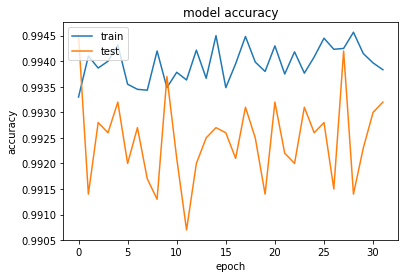

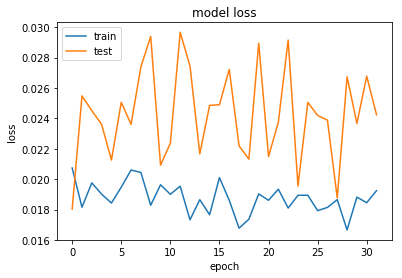

In [36]:
import matplotlib.pyplot as plt

axes = plt.gca()
#axes.set_xlim([1,5])
#axes.set_ylim([0.2,1.0])

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Try evaluation only with best performing models
last result: 0.26% test error rate on ensemble of 10 CNNs
1. 0.38999915123
2. 0.540000200272
3. 0.400000810623
4. 0.38999915123
5. 0.540000200272
6. 0.480002164841
7. 0.480002164841
8. 0.499999523163
9. 0.419998168945
10. 0.400000810623

Models trained for 112 epochs:
1. 1,8 : 0.26
2. 0,1,2,8: 0.25
3. 0,1,2,8,5: 0.24

In [287]:
best_model_numbers = [0,1,2,8,5]

In [288]:
best_models = []

for i in best_model_numbers:
    best_models.append(models[i])

In [289]:
all_preds = np.stack([m.predict(x_test, batch_size=eval_batch_size) for m in best_models])

In [290]:
avg_preds = all_preds.mean(axis=0)

In [291]:
# display error rate in percent
(1 - keras.metrics.categorical_accuracy(y_test, avg_preds).eval().mean()) * 100

0.29000043869018555

# Train single model some more

Select a single model, train for a few epochs, and check accuracy.

In [57]:
# which model to train
i = 1

In [58]:
# reload weights in case of overfitting
# models[i].load_weights("weights/weights_emnist_model_0.2475_"+str(i)+'.pkl')

In [59]:
models[i].optimizer.lr = 0.0001
history = models[i].fit_generator(batches, steps_per_epoch=steps_per_epoch, epochs=4,
                   validation_data=test_batches, validation_steps=validation_steps)

Epoch 1/4
469/469 [==============================] - 40s - loss: 0.0156 - acc: 0.9956 - val_loss: 0.0147 - val_acc: 0.9963
Epoch 2/4
469/469 [==============================] - 40s - loss: 0.0162 - acc: 0.9954 - val_loss: 0.0156 - val_acc: 0.9956
Epoch 3/4
469/469 [==============================] - 40s - loss: 0.0161 - acc: 0.9954 - val_loss: 0.0157 - val_acc: 0.9958
Epoch 4/4
469/469 [==============================] - 39s - loss: 0.0156 - acc: 0.9956 - val_loss: 0.0142 - val_acc: 0.9959


In [60]:
# calculate accuracy of single model
pred = np.array(models[i].predict(x_test, batch_size=eval_batch_size))
print(i, (1 - keras.metrics.categorical_accuracy(y_test, pred).eval().mean()) * 100)

1 0.227499008179


In [54]:
# models[i].save_weights("weights/weights_emnist_model_0.2475_"+str(i)+'.pkl')

# Visualize model

In [34]:
models[0].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 1, 28, 28)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 26, 26)        320       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 26, 26)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 26, 26)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 24, 24)        9248      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 24, 24)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 12, 12)        0         
__________

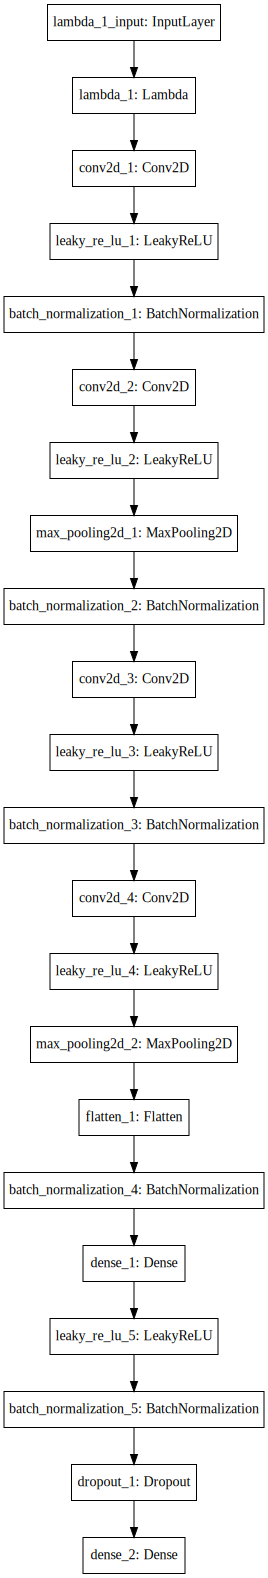

In [35]:
# fix for python3
import pydotplus as pydot

from keras.utils import plot_model
plot_model(models[0], to_file='model.png')

# visualize our model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(models[0]).create(prog='dot', format='svg'))

# Visualize predictions for best performing single model
As well as looking at the overall metrics, it's also a good idea to look at examples of:
1. A few correct labels at random
2. A few incorrect labels at random

In [36]:
m = create_model()

In [37]:
# load saved weights
m.load_weights("weights/weights_mnist+32epochs_1.pkl")

In [38]:
# predict classes
preds = m.predict_classes(x_test, batch_size=eval_batch_size)

38912/40000 [============================>.] - ETA: 0s

In [39]:
preds.shape

(40000,)

In [40]:
test_labels.shape

(40000,)

In [41]:
correct = np.where(preds==test_labels)[0]

In [42]:
incorrect = np.where(preds!=test_labels)[0]

In [43]:
correct.shape

(39913,)

In [44]:
incorrect.shape

(87,)

In [45]:
# number of images to view
n_view = 30

In [46]:
from numpy.random import permutation

# get a random selection of correctly predicted images
idx = permutation(correct)[:n_view]
idx_incorrect = permutation(incorrect)[:n_view]

In [47]:
preds_correct = preds[idx]
preds_incorrect = preds[idx_incorrect]

In [48]:
imgs = x_test[idx]
imgs_incorrect = x_test[idx_incorrect]

In [49]:
imgs.shape

(30, 1, 28, 28)

### A few correct labels at random

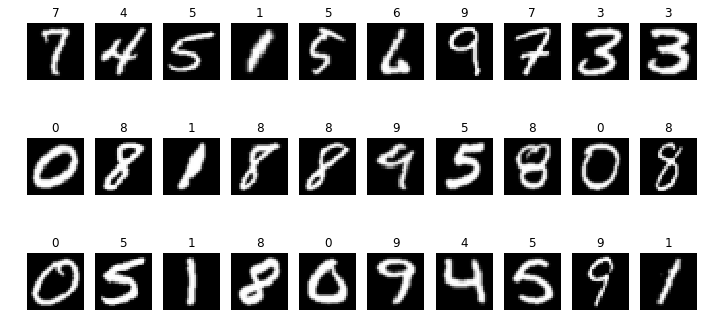

In [50]:
f = plt.figure(figsize=(12,6))

for i in range(n_view):
    sp = f.add_subplot(3, 10, i+1)
    sp.axis('Off')
    sp.set_title(preds_correct[i])
    img = imgs[i].astype('float32')
    plt.imshow(img[0], cmap='gray')

In [51]:
# ground truth labels
test_labels[idx]

array([7, 4, 5, 1, 5, 6, 9, 7, 3, 3, 0, 8, 1, 8, 8, 9, 5, 8, 0, 8, 0, 5, 1,
       8, 0, 9, 4, 5, 9, 1], dtype=uint8)

### a few incorrect labels at random

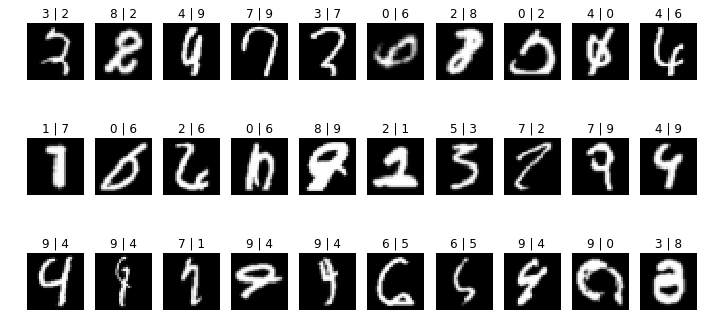

In [52]:
f = plt.figure(figsize=(12,6))

for i in range(n_view): 
    sp = f.add_subplot(3, 10, i+1)
    sp.axis('Off')
    sp.set_title("{} | {}".format(preds_incorrect[i],test_labels[idx_incorrect][i]))
    img = imgs_incorrect[i].astype('float32')
    plt.imshow(img[0], cmap='gray')

In [53]:
# ground truth labels
test_labels[idx_incorrect]

array([2, 2, 9, 9, 7, 6, 8, 2, 0, 6, 7, 6, 6, 6, 9, 1, 3, 2, 9, 9, 4, 4, 1,
       4, 4, 5, 5, 4, 0, 8], dtype=uint8)

# Print confusion matrix

Plot unnormalized and normalized confusion matrices. Code adapted from 
http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html


In [54]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [55]:
# calculate confusion matrix
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(test_labels, preds)

Confusion matrix, without normalization
[[3992    1    1    0    1    1    1    0    0    3]
 [   0 3994    1    0    1    0    0    3    1    0]
 [   1    1 3992    3    0    0    0    2    1    0]
 [   0    0    2 3991    0    5    0    0    2    0]
 [   0    0    0    0 3988    0    1    1    1    9]
 [   0    1    0    3    0 3994    2    0    0    0]
 [   3    0    1    0    1    1 3994    0    0    0]
 [   0    1    3    1    1    0    0 3994    0    0]
 [   1    2    3    2    1    0    1    0 3988    2]
 [   0    0    0    0    6    4    0    3    1 3986]]
Normalized confusion matrix
[[  9.98e-01   2.50e-04   2.50e-04   0.00e+00   2.50e-04   2.50e-04
    2.50e-04   0.00e+00   0.00e+00   7.50e-04]
 [  0.00e+00   9.99e-01   2.50e-04   0.00e+00   2.50e-04   0.00e+00
    0.00e+00   7.50e-04   2.50e-04   0.00e+00]
 [  2.50e-04   2.50e-04   9.98e-01   7.50e-04   0.00e+00   0.00e+00
    0.00e+00   5.00e-04   2.50e-04   0.00e+00]
 [  0.00e+00   0.00e+00   5.00e-04   9.98e-01   0.00e+00

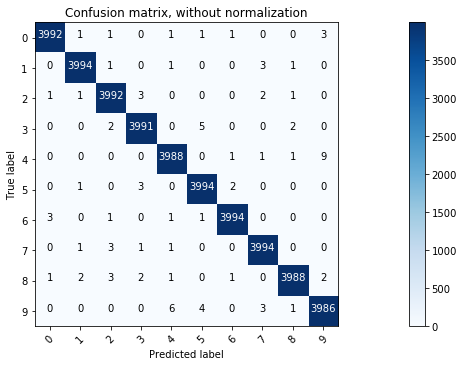

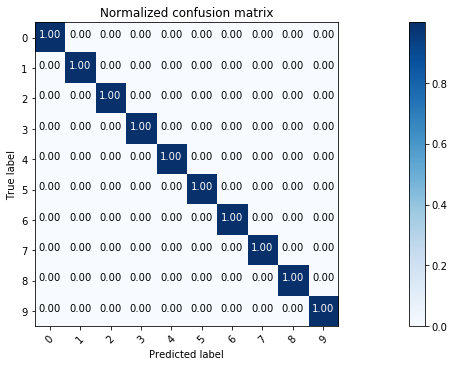

In [56]:
import itertools

class_names = [i for i in range(10)]
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,5))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(20,5))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

# Save weights if models are accurate enough

In [36]:
# save the weights for every classifier
for i, m in enumerate(models):
    m.save_weights("weights/weights_mnist+xxepochs_"+str(i)+'.pkl')